In [4]:
import argparse
import numpy as np
import os
import torch
from libs.wsol.model.backbone import resnet50
import cv2
from libs.inference import normalize_scoremap
from libs.util import generate_vis, t2n
from libs.wsol.model.classifier import CAMClassifier
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
_IMAGE_MEAN_VALUE = [0.485, 0.456, 0.406]
_IMAGE_STD_VALUE = [0.229, 0.224, 0.225]
crop_size = 224
trans = transforms.Compose([
            transforms.Resize((crop_size, crop_size)),
            transforms.ToTensor(),
            transforms.Normalize(_IMAGE_MEAN_VALUE, _IMAGE_STD_VALUE)
        ])

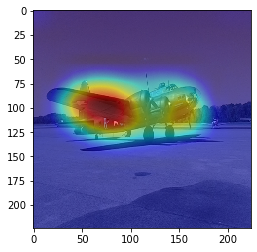

In [6]:
###Choose input images###
img_path = "demo_imgs/plane.jpg"
check_path= "dawsol_openimages.tar"

###Open the images###
image = Image.open(img_path)
image = image.convert('RGB')
image = trans(image)
image = image.unsqueeze(0)
image_size = image.shape[2:]

###Define our model###
extractor = resnet50(
                dataset_name="OpenImages",
                architecture_type="cam",
                pretrained=False,
                large_feature_map=False)
classifier = CAMClassifier(100, num_feature=2048)

###Load checkpoint###
checkpoint = torch.load(check_path, map_location=torch.device('cpu'))
extractor.load_state_dict(checkpoint['state_dict_extractor'], strict=True)
classifier.load_state_dict(checkpoint['state_dict_classifier'], strict=True)
extractor.eval()
classifier.eval()

###Generate localization Map and Class Label###
pixel_feature = extractor(image)
image_feature = nn.AdaptiveAvgPool2d(1)(pixel_feature)
class_logits = classifier(image_feature)
predict_class = torch.argmax(class_logits, dim=1)
predict_class = np.int64(t2n(predict_class)[0, 0, 0])

cam = classifier(pixel_feature) # class-aware localization map
cam = t2n(cam)[0, predict_class, :, :] # choose the class
cam = cv2.resize(cam, image_size, interpolation=cv2.INTER_CUBIC) 
cam = normalize_scoremap(cam) #normalize localization map

vis_img = cv2.resize(np.array(cv2.imread(img_path)), (crop_size,crop_size))
vis_cam = generate_vis(cam, vis_img.transpose(2, 0, 1)).transpose(1, 2, 0)

plt.imshow(vis_cam)